# 0. Import des packages et des données 

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from helpers2 import S3Connection

In [2]:
from postal.expand import expand_address

In [3]:
s3 = S3Connection(bucket_name="clichere/diffusion")

Connection successful


In [4]:
path1 = "DPE/DPE_logements.parquet"
DPE = s3.get_tables_from_s3(path1)

In [5]:
path_vf_2024 = "valeursfoncieres/vf_2024.csv"
vf_2024 = s3.read_csv_from_s3(path_vf_2024)

path_vf_2023 = "valeursfoncieres/vf_2023.csv"
vf_2023 = s3.read_csv_from_s3(path_vf_2023)

path_vf_2022 = "valeursfoncieres/vf_2022.csv"
vf_2022 = s3.read_csv_from_s3(path_vf_2022)

path_vf_2021 = "valeursfoncieres/vf_2021.csv"
vf_2021 = s3.read_csv_from_s3(path_vf_2021)

path_vf_2020 = "valeursfoncieres/vf_2020.csv"
vf_2020 = s3.read_csv_from_s3(path_vf_2020)

path_vf_2019 = "valeursfoncieres/vf_2019.csv"
vf_2019 = s3.read_csv_from_s3(path_vf_2019)

# 1. FONCTIONS UTILES

Normalisation des adresses du fichier DPE et valeurs foncières. 

In [6]:
def normalize_address(address):
    if pd.isna(address) or address.strip() == '':
        return None  
    try:
        normalized = expand_address(address)  
        return normalized[0] if normalized else None  # Ne garde que la première version de la normalisation
    except Exception as e:
        print(f"Erreur avec l'adresse '{address}': {e}")
        return None

In [7]:
import re

def normalize_vf_address(address, code_postal):
    """Normalise l'adresse et supprime l'arrondissement après 'Paris' uniquement si le code postal commence par 75."""
    normalized_address = normalize_address(address)  # ta fonction de normalisation de base

    if pd.notna(normalized_address) and str(code_postal).startswith("75"):
        # Supprime les variantes de type "Paris 1er Arrondissement", "Paris 3e Arrondissement", etc.
        normalized_address = re.sub(r'(paris)\s+\d{1,2}(?:er|e)?\s+arrondissement', r'\1', normalized_address, flags=re.IGNORECASE)

    return normalized_address


FONCTION DE MATCHING

In [8]:
def test_match(vf, df):
    merged = []


    #boucle par département
    for department in df['N°_département_(BAN)'].unique():  
        print(f"Traitement du département : {department}")
        
        #filtre
        vf_dept = vf[vf['code_departement']==department].copy()
        df_dept = df[df['N°_département_(BAN)']==department].copy()

        #normalisation adresses
        vf_dept['Adresse'] = vf_dept['Adresse'].str.strip().str.replace(r'\s+', ' ', regex=True)
        vf_dept['Adresse_Normalisee'] = vf_dept.apply(lambda row: normalize_vf_address(row['Adresse'], row['code_departement']), axis=1)
        df_dept['Adresse_Normalisee'] = df_dept['Adresse_(BAN)'].apply(normalize_address)

        #On distingue les adresses uniques et les adresses en doublons pour avoir deux catégories d'adresses et trouver celles communes aux deux bases
        adresse_counts = vf_dept['Adresse_Normalisee'].dropna().value_counts()
        unique1 = list(adresse_counts[adresse_counts == 1].index)
        doublons1 = list(adresse_counts[adresse_counts > 1].index)
        final = unique1 + doublons1
        set_final = set(final)

        adresse_counts2 = df_dept['Adresse_Normalisee'].dropna().value_counts()
        unique2 = list(adresse_counts2[adresse_counts2 == 1].index)
        doublons2 = list(adresse_counts2[adresse_counts2 > 1].index)
        final2 = unique2 + doublons2
        set_final2 = set(final2)

        # On regarde les adresses communes
        commun = set_final.intersection(set_final2)

        vf_dept['surface_reelle_bati'] = pd.to_numeric(
            vf_dept['surface_reelle_bati'].astype(str).str.replace(',', '.'), errors='coerce'
        )
        df_dept['Surface_habitable_logement'] = pd.to_numeric(
            df_dept['Surface_habitable_logement'].astype(str).str.replace(',', '.'), errors='coerce'
        )

        for adresse in commun:
            # On crée des sous dataframe contenant les lignes avec les mêmes adresses
            dfsub = df_dept[df_dept['Adresse_Normalisee'] == adresse]
            vfsub = vf_dept[vf_dept['Adresse_Normalisee'] == adresse]

            # Boucle sur les rangs des sous dataframe
            for _, row2 in dfsub.iterrows():
                best_match = None
                best_value = -1

                for _, row1 in vfsub.iterrows():
                    surface1 = row1['surface_reelle_bati']
                    surface2 = row2['Surface_habitable_logement']

                    #si surfaces identiques on match direct
                    if surface1 == surface2:
                        best_match = row1
                        break

                    #ecart inf à 5% et parmi les lignes avec des surfaces inf au seuil si jamais la valeur foncière est supérieure à celle de la ligne d'avant on la conserve pour avoir la plus grande
                    if abs(surface1 - surface2) / max(surface1, surface2) < 0.05:
                        valeur_fonciere = pd.to_numeric(str(row1.get('valeur_fonciere', 0)).replace(',', '.'), errors='coerce')
                        if valeur_fonciere > best_value:
                            best_value = valeur_fonciere
                            best_match = row1

                if best_match is not None:
                    merged.append({**row2.to_dict(), **best_match.to_dict()})

    #df des résultats fusionnés
    df = pd.DataFrame(merged)
    return df.drop_duplicates(subset=['Date_établissement_DPE', 'Adresse_Normalisee', 'Surface_habitable_logement', 'valeur_fonciere', 'Etiquette_DPE'])


In [9]:
def compiler_dataframes(*dfs):
    # Concatène tous les DataFrames passés en argument
    df_compilé = pd.concat(dfs, ignore_index=True)
    # Supprime les doublons
    df_compilé = df_compilé.drop_duplicates()
    return df_compilé

Fonction pour mettre en forme les fichiers valeurs foncières.

In [10]:
def format_vf(vf):
    # formatage code département
    vf['code_departement'] = vf['code_departement'].astype(str).str.zfill(2)

    # formatage code postal avec 5 chiffres comme dans DPE 
    vf['code_postal'] = vf['code_postal'].apply(lambda x: str(int(x)).zfill(5) if pd.notna(x) and x != '' else '')

    # construction de l'adresse formatée
    vf['Adresse'] = vf['adresse_numero'].apply(lambda x: str(int(x)) if pd.notna(x) else '').astype(str) + " " + \
                    vf['adresse_nom_voie'].fillna('').astype(str) + " " + \
                    vf['code_postal'] + " " + \
                    vf['nom_commune'].fillna('').astype(str)

    # Supprime les adresses vides ou remplies d'espaces
    vf['Adresse'] = vf['Adresse'].str.strip().replace(r'^\s*$', None, regex=True)

    return vf

Fonction pour mettre en forme le fichier DPE. 

In [11]:
def format_dpe(df,annee):
    df['Date_établissement_DPE'] = pd.to_datetime(df['Date_établissement_DPE'], errors='coerce')
    df = df[df['Date_établissement_DPE'].dt.year == annee].copy()
    df = df[df['N°_département_(BAN)'].notna()]
    df.loc[:, 'N°_département_(BAN)'] = df['N°_département_(BAN)'].astype(str)
    df = df[df['Etiquette_DPE'].isin(['A', 'B', 'C', 'D', 'E', 'F', 'G'])]

    return df

# 2. Année 2019

In [19]:
v2019 = format_vf(vf_2019)

In [42]:
d2019 = format_dpe(DPE, 2019)

In [43]:
match2019 = test_match(v2019,d2019)

Traitement du département : 48
Traitement du département : 2A
Traitement du département : 2B
Traitement du département : 23
Traitement du département : 15
Traitement du département : 55
Traitement du département : 90
Traitement du département : 43
Traitement du département : 09
Traitement du département : 46
Traitement du département : 52
Traitement du département : 27
Traitement du département : 58
Traitement du département : 32
Traitement du département : 05
Traitement du département : 82
Traitement du département : 19
Traitement du département : 70
Traitement du département : 04
Traitement du département : 36
Traitement du département : 65
Traitement du département : 61
Traitement du département : 18
Traitement du département : 12
Traitement du département : 10
Traitement du département : 39
Traitement du département : 08
Traitement du département : 89
Traitement du département : 07
Traitement du département : 16
Traitement du département : 41
Traitement du département : 88
Traiteme

In [44]:
print(len(match2019))

64223


In [45]:
match2019.to_csv('final2019.csv',index=False)

In [ ]:
# La fonction ci-dessous écrit le df dans le s3, seules les personnes autorisées peuvent le faire
outpath_df_2019 = "vf_DPE/vf_DPE_2019.parquet"
s3.from_pandas_to_parquet_store_in_s3(match2019, outpath_df_2019)

Fichier Parquet écrit avec succès dans vf_DPE/vf_DPE_2019.parquet


# 3. Année 2020

In [46]:
v2020 = format_vf(vf_2020)

In [47]:
d2020 = format_dpe(DPE, 2020)

In [48]:
match2020 = test_match(v2020,d2020)

Traitement du département : 48
Traitement du département : 2B
Traitement du département : 2A
Traitement du département : 23
Traitement du département : 55
Traitement du département : 15
Traitement du département : 90
Traitement du département : 43
Traitement du département : 09
Traitement du département : 52
Traitement du département : 46
Traitement du département : 58
Traitement du département : 32
Traitement du département : 05
Traitement du département : 70
Traitement du département : 82
Traitement du département : 19
Traitement du département : 04
Traitement du département : 65
Traitement du département : 61
Traitement du département : 89
Traitement du département : 18
Traitement du département : 10
Traitement du département : 12
Traitement du département : 08
Traitement du département : 39
Traitement du département : 36
Traitement du département : 41
Traitement du département : 07
Traitement du département : 16
Traitement du département : 03
Traitement du département : 88
Traiteme

In [49]:
print(len(match2020))

76419


In [50]:
match2020.to_csv('final2020.csv',index=False)

In [ ]:
# La fonction ci-dessous écrit le df dans le s3, seules les personnes autorisées peuvent le faire
outpath_df_2020 = "vf_DPE/vf_DPE_2020.parquet"
s3.from_pandas_to_parquet_store_in_s3(match2020, outpath_df_2020)

Fichier Parquet écrit avec succès dans vf_DPE/vf_DPE_2020.parquet


# 4. Année 2021

In [51]:
v2021 = format_vf(vf_2021)

In [52]:
d2021 = format_dpe(DPE,2021)

In [53]:
match2021 = test_match(v2021,d2021)

Traitement du département : 48
Traitement du département : 2B
Traitement du département : 2A
Traitement du département : 55
Traitement du département : 15
Traitement du département : 23
Traitement du département : 90
Traitement du département : 43
Traitement du département : 09
Traitement du département : 46
Traitement du département : 52
Traitement du département : 58
Traitement du département : 32
Traitement du département : 05
Traitement du département : 70
Traitement du département : 19
Traitement du département : 04
Traitement du département : 82
Traitement du département : 08
Traitement du département : 18
Traitement du département : 10
Traitement du département : 61
Traitement du département : 36
Traitement du département : 12
Traitement du département : 65
Traitement du département : 40
Traitement du département : 39
Traitement du département : 16
Traitement du département : 41
Traitement du département : 07
Traitement du département : 03
Traitement du département : 89
Traiteme

In [54]:
print(len(match2021))

119958


In [55]:
match2021.to_csv('final2021.csv',index=False)

In [24]:
# La fonction ci-dessous écrit le df dans le s3, seuls les personnes autorisées peuvent le faire
outpath_df_2021 = "vf_DPE/vf_DPE_2021.parquet"
s3.from_pandas_to_parquet_store_in_s3(match2021, outpath_df_2021)

Fichier Parquet écrit avec succès dans vf_DPE/vf_DPE_2021.parquet


# 5. Année 2022

In [13]:
v2022 = format_vf(vf_2022)

In [14]:
d2022 = format_dpe(DPE,2022)

In [15]:
match2022 = test_match(v2022,d2022)

Traitement du département : 14
Traitement du département : 58
Traitement du département : 44
Traitement du département : 68
Traitement du département : 71
Traitement du département : 62
Traitement du département : 74
Traitement du département : 17
Traitement du département : 83
Traitement du département : 34
Traitement du département : 33
Traitement du département : 91
Traitement du département : 21
Traitement du département : 11
Traitement du département : 02
Traitement du département : 92
Traitement du département : 59
Traitement du département : 94
Traitement du département : 75
Traitement du département : 50
Traitement du département : 37
Traitement du département : 13
Traitement du département : 81
Traitement du département : 67
Traitement du département : 93
Traitement du département : 29
Traitement du département : 63
Traitement du département : 36
Traitement du département : 95
Traitement du département : 76
Traitement du département : 78
Traitement du département : 38
Traiteme

In [16]:
print(len(match2022))

201070


In [17]:
match2022.to_csv('final2022.csv',index=False)

In [ ]:
# La fonction ci-dessous écrit le df dans le s3, seuls les personnes autorisées peuvent le faire
outpath_df_2022 = "vf_DPE/vf_DPE_2022.parquet"
s3.from_pandas_to_parquet_store_in_s3(match2022, outpath_df_2022)

# 6. Année 2023

In [26]:
v2023 = format_vf(vf_2023)

In [19]:
d2023 = format_dpe(DPE, 2023)

In [20]:
match2023 = test_match(v2023,d2023)

Traitement du département : 84


Traitement du département : 32
Traitement du département : 59
Traitement du département : 34
Traitement du département : 56
Traitement du département : 44
Traitement du département : 76
Traitement du département : 35
Traitement du département : 93
Traitement du département : 49
Traitement du département : 69
Traitement du département : 77
Traitement du département : 83
Traitement du département : 75
Traitement du département : 22
Traitement du département : 16
Traitement du département : 78
Traitement du département : 73
Traitement du département : 50
Traitement du département : 92
Traitement du département : 80
Traitement du département : 11
Traitement du département : 67
Traitement du département : 30
Traitement du département : 14
Traitement du département : 60
Traitement du département : 64
Traitement du département : 94
Traitement du département : 29
Traitement du département : 28
Traitement du département : 91
Traitement du département : 13
Traitement du département : 62
Traiteme

In [21]:
print(len(match2023))

112581


In [22]:
match2023.to_csv('final2023.csv',index=False)

In [ ]:
# La fonction ci-dessous écrit le df dans le s3, seuls les personnes autorisées peuvent le faire
outpath_df_2023 = "vf_DPE/vf_DPE_2023.parquet"
s3.from_pandas_to_parquet_store_in_s3(match2023, outpath_df_2023)

# 7. Année 2024

In [44]:
print(len(vf_2024))

1566643


In [41]:
v2024 = format_vf(vf_2024)

In [42]:
d2024 = format_dpe(DPE,2024)

In [45]:
print(len(d2024))

9


In [43]:
match2024 = test_match(v2024,d2024)

Traitement du département : 65
Traitement du département : 06


In [65]:
print(len(match2024))

0


In [ ]:
# La fonction ci-dessous écrit le df dans le s3, seuls les personnes autorisées peuvent le faire
outpath_df_2024 = "vf_DPE/vf_DPE_2024.parquet"
s3.from_pandas_to_parquet_store_in_s3(match2024, outpath_df_2024)

# 8. Matching des 6 bases de données

In [67]:
result = compiler_dataframes(match2019,match2020,match2021,match2022,match2023,match2024)

In [ ]:
# La fonction ci-dessous écrit le df dans le s3, seuls les personnes autorisées peuvent le faire
outpath_df = "vf_DPE/vf_DPE.parquet"
s3.from_pandas_to_parquet_store_in_s3(result, outpath_df)

In [68]:
print(len(result))

512824


# TEST SURFACES

In [12]:
def test_matchsurface(vf, df, surface):
    merged = []


    #boucle par département
    for department in df['N°_département_(BAN)'].unique():  
        print(f"Traitement du département : {department}")
        
        #filtre
        vf_dept = vf[vf['code_departement']==department].copy()
        df_dept = df[df['N°_département_(BAN)']==department].copy()

        #normalisation adresses
        vf_dept['Adresse'] = vf_dept['Adresse'].str.strip().str.replace(r'\s+', ' ', regex=True)
        vf_dept['Adresse_Normalisee'] = vf_dept.apply(lambda row: normalize_vf_address(row['Adresse'], row['code_departement']), axis=1)
        df_dept['Adresse_Normalisee'] = df_dept['Adresse_(BAN)'].apply(normalize_address)

        #On distingue les adresses uniques et les adresses en doublons pour avoir deux catégories d'adresses et trouver celles communes aux deux bases
        adresse_counts = vf_dept['Adresse_Normalisee'].dropna().value_counts()
        unique1 = list(adresse_counts[adresse_counts == 1].index)
        doublons1 = list(adresse_counts[adresse_counts > 1].index)
        final = unique1 + doublons1
        set_final = set(final)

        adresse_counts2 = df_dept['Adresse_Normalisee'].dropna().value_counts()
        unique2 = list(adresse_counts2[adresse_counts2 == 1].index)
        doublons2 = list(adresse_counts2[adresse_counts2 > 1].index)
        final2 = unique2 + doublons2
        set_final2 = set(final2)

        # On regarde les adresses communes
        commun = set_final.intersection(set_final2)

        vf_dept[surface] = pd.to_numeric(
            vf_dept[surface].astype(str).str.replace(',', '.'), errors='coerce'
        )
        df_dept['Surface_habitable_logement'] = pd.to_numeric(
            df_dept['Surface_habitable_logement'].astype(str).str.replace(',', '.'), errors='coerce'
        )

        for adresse in commun:
            # On crée des sous dataframe contenant les lignes avec les mêmes adresses
            dfsub = df_dept[df_dept['Adresse_Normalisee'] == adresse]
            vfsub = vf_dept[vf_dept['Adresse_Normalisee'] == adresse]

            # Boucle sur les rangs des sous dataframe
            for _, row2 in dfsub.iterrows():
                best_match = None
                best_value = -1

                for _, row1 in vfsub.iterrows():
                    surface1 = row1[surface]
                    surface2 = row2['Surface_habitable_logement']

                    #si surfaces identiques on match direct
                    if surface1 == surface2:
                        best_match = row1
                        break

                    #ecart inf à 5% et parmi les lignes avec des surfaces inf au seuil si jamais la valeur foncière est supérieure à celle de la ligne d'avant on la conserve pour avoir la plus grande
                    if abs(surface1 - surface2) / max(surface1, surface2) < 0.05:
                        valeur_fonciere = pd.to_numeric(str(row1.get('valeur_fonciere', 0)).replace(',', '.'), errors='coerce')
                        if valeur_fonciere > best_value:
                            best_value = valeur_fonciere
                            best_match = row1

                if best_match is not None:
                    merged.append({**row2.to_dict(), **best_match.to_dict()})

    #df des résultats fusionnés
    df = pd.DataFrame(merged)
    return df.drop_duplicates(subset=['Date_établissement_DPE', 'Adresse_Normalisee', 'Surface_habitable_logement', 'valeur_fonciere', 'Etiquette_DPE'])


In [14]:
print(vf_2022.columns)

Index(['id_mutation', 'date_mutation', 'numero_disposition', 'nature_mutation',
       'valeur_fonciere', 'adresse_numero', 'adresse_suffixe',
       'adresse_nom_voie', 'adresse_code_voie', 'code_postal', 'code_commune',
       'nom_commune', 'code_departement', 'ancien_code_commune',
       'ancien_nom_commune', 'id_parcelle', 'ancien_id_parcelle',
       'numero_volume', 'lot1_numero', 'lot1_surface_carrez', 'lot2_numero',
       'lot2_surface_carrez', 'lot3_numero', 'lot3_surface_carrez',
       'lot4_numero', 'lot4_surface_carrez', 'lot5_numero',
       'lot5_surface_carrez', 'nombre_lots', 'code_type_local', 'type_local',
       'surface_reelle_bati', 'nombre_pieces_principales',
       'code_nature_culture', 'nature_culture', 'code_nature_culture_speciale',
       'nature_culture_speciale', 'surface_terrain', 'longitude', 'latitude'],
      dtype='object')


In [21]:
# 1. Mise en forme des données
vf_2023_formate = format_vf(vf_2023)
dpe_2023_formate = format_dpe(DPE, 2023)

# 2. Restriction au département 91 uniquement
vf_91 = vf_2023_formate[vf_2023_formate['code_departement'] == '91'].copy()
dpe_91 = dpe_2023_formate[dpe_2023_formate['N°_département_(BAN)'] == '91'].copy()

# 3. Matching surface reelle 
match_reelle = test_matchsurface(vf_91,dpe_91,'surface_reelle_bati')

# 4. Matching surface carrez
match_carrez = test_matchsurface(vf_91,dpe_91,'lot1_surface_carrez')

# 7. Statistiques comparatives
def analyse_resultats(df, label):
    dpe_numeric = df['Etiquette_DPE'].map({'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7})
    print(f" Résultats - {label}")
    print(f"- Nombre de correspondances : {len(df)}")
    print(f"- DPE moyen : {dpe_numeric.mean():.2f}")
    print(f"- Répartition DPE :\n{df['Etiquette_DPE'].value_counts().sort_index()}\n")

analyse_resultats(match_reelle, "Surface réelle")
analyse_resultats(match_carrez, "Surface Carrez")


Traitement du département : 91
Traitement du département : 91
 Résultats - Surface réelle
- Nombre de correspondances : 2460
- DPE moyen : 4.25
- Répartition DPE :
Etiquette_DPE
A      5
B     76
C    590
D    878
E    578
F    194
G    139
Name: count, dtype: int64

 Résultats - Surface Carrez
- Nombre de correspondances : 1631
- DPE moyen : 4.17
- Répartition DPE :
Etiquette_DPE
A      2
B     54
C    437
D    567
E    387
F    107
G     77
Name: count, dtype: int64



In [14]:
DPE['Date_établissement_DPE'] = pd.to_datetime(DPE['Date_établissement_DPE'], errors='coerce')
DPE2023 = DPE[DPE['Date_établissement_DPE'].dt.year == 2023].copy()

In [18]:
DPE2023 = DPE2023[DPE2023['Etiquette_DPE'].isin(['A', 'B', 'C', 'D', 'E', 'F', 'G'])]

In [26]:
dpe91 = DPE2023[DPE2023['N°_département_(BAN)'] == '91'].copy()

In [27]:
dpe91 = dpe91[dpe91['Etiquette_DPE'].isin(['A', 'B', 'C', 'D', 'E', 'F', 'G'])]

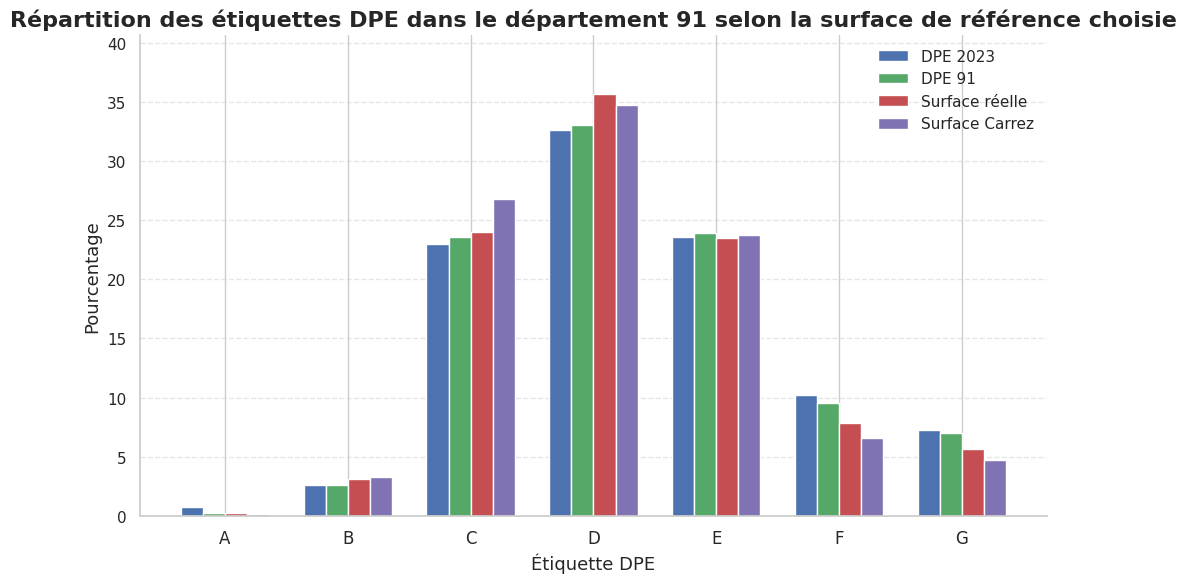

In [34]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

# Ordre des DPE
dpe_order = ['A', 'B', 'C', 'D', 'E', 'F', 'G']

# Fonction pour calculer les pourcentages
def dpe_percent(df, col="Etiquette_DPE"):
    res = df[col].value_counts(normalize=True) * 100
    return res.reindex(dpe_order, fill_value=0)

# Calculs
dpe_reelle = dpe_percent(match_reelle)
dpe_carrez = dpe_percent(match_carrez)
dpe_91 = dpe_percent(dpe91)
dpe_2023 = dpe_percent(DPE2023)

# Réorganisation des colonnes
dpe_df = pd.DataFrame({
    "DPE 2023": dpe_2023,
    "DPE 91": dpe_91,
    "Surface réelle": dpe_reelle,
    "Surface Carrez": dpe_carrez
}, index=dpe_order)

# Style seaborn
sns.set(style="whitegrid")

# Paramètres
bar_width = 0.18
x = np.arange(len(dpe_order))

# Couleurs harmonisées
colors = ["#4C72B0", "#55A868", "#C44E52", "#8172B3"]

# Création du graphique
fig, ax = plt.subplots(figsize=(10, 6))

# Barres (espacées proprement)
ax.bar(x - 1.5*bar_width, dpe_df["DPE 2023"], width=bar_width, label="DPE 2023", color=colors[0])
ax.bar(x - 0.5*bar_width, dpe_df["DPE 91"], width=bar_width, label="DPE 91", color=colors[1])
ax.bar(x + 0.5*bar_width, dpe_df["Surface réelle"], width=bar_width, label="Surface réelle", color=colors[2])
ax.bar(x + 1.5*bar_width, dpe_df["Surface Carrez"], width=bar_width, label="Surface Carrez", color=colors[3])

# Titres et axes
ax.set_title("Répartition des étiquettes DPE dans le département 91 selon la surface de référence choisie", fontsize=16, fontweight='bold')
ax.set_xlabel("Étiquette DPE", fontsize=13)
ax.set_ylabel("Pourcentage", fontsize=13)
ax.set_xticks(x)
ax.set_xticklabels(dpe_order, fontsize=12)
ax.legend(fontsize=11, frameon=False)
ax.set_ylim(0, dpe_df.max().max() + 5)

# Grille légère
ax.yaxis.grid(True, linestyle='--', alpha=0.5)

# Suppression des bordures inutiles
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

# Affichage
plt.tight_layout()
plt.show()


In [60]:
vf91 = vf_2023[vf_2023['code_departement']=='91'].copy()

In [59]:
# Calcul de la valeur foncière moyenne pour chaque base
valeur_fonciere_moyenne_reelle = match_reelle["valeur_fonciere"].mean()
valeur_fonciere_moyenne_carrez = match_carrez["valeur_fonciere"].mean()
valeur_fonciere_moyenne_91 = vf91["valeur_fonciere"].mean()
valeur_fonciere_moyenne_2023 = vf_2023["valeur_fonciere"].mean()

# Afficher les résultats
print("Valeur foncière moyenne pour chaque base :")
print(f"Surface réelle : {valeur_fonciere_moyenne_reelle:.2f} €")
print(f"Surface Carrez : {valeur_fonciere_moyenne_carrez:.2f} €")
print(f"vf 91 : {valeur_fonciere_moyenne_91:.2f} €")
print(f"vf 2023 : {valeur_fonciere_moyenne_2023:.2f} €")


Valeur foncière moyenne pour chaque base :
Surface réelle : 242384.45 €
Surface Carrez : 187958.72 €
vf 91 : 387086.45 €
vf 2023 : 617410.43 €


In [62]:
# Calcul de la médiane pour chaque base de données
mediane_dpe91 = vf91['valeur_fonciere'].median()
mediane_match_reelle = match_reelle['valeur_fonciere'].median()
mediane_match_carrez = match_carrez['valeur_fonciere'].median()
mediane_dpe2023 = vf_2023['valeur_fonciere'].median()

# Affichage des résultats
print(f"Médiane vf 91 : {mediane_dpe91} €")
print(f"Médiane Surface réelle : {mediane_match_reelle} €")
print(f"Médiane Surface Carrez : {mediane_match_carrez} €")
print(f"Médiane vf 2023 : {mediane_dpe2023} €")


Médiane vf 91 : 216000.0 €
Médiane Surface réelle : 195000.0 €
Médiane Surface Carrez : 166700.0 €
Médiane vf 2023 : 160000.0 €
